# ARSA FİYATI TAHMİNLEME PROJESİ

In [22]:
import csv
from past.builtins import raw_input
from pyparsing import col
import pandas as pd
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold

In [3]:
df_train = pd.read_csv('/home/melek/PycharmProjects/webCrawl/DATA.csv',encoding="UTF-8",sep=",")

df_train


,FIYAT,IL,ILCE,MAHALLE,ILAN_NO,ARSA_TIPI,METREKARE,TAPU_DURUMU,ILGILI_BELEDIYE,METREKARE_BIRIM_FIYAT,...,PARSEL,KIRA_GETIRISI,TAKAS_BILINMIYOR,TAKAS_EVET,TAKAS_HAYIR,KAT_KARSILIGI_EVET,KAT_KARSILIGI_HAYIR,KREDIYE_UYGUNLUK_BILINMIYOR,KREDIYE_UYGUNLUK_UYGUN,KREDIYE_UYGUNLUK_UYGUN DEGIL
0,165000,BALIKESIR,AYVALIK,ALTINOVA,42916-1540,I_K,255,MUSTAKIL PARSEL,AYVALIK,NaN,...,NaN,NaN,0,1,0,0,1,0,1,0
1,240000,BURSA,YENISEHIR,KOZDERE,69245-16,TARLA,7750,MUSTAKIL PARSEL,YENISEHIR,35.0,...,53.0,NaN,0,0,1,0,1,0,0,1
2,5000000,NIGDE,MERKEZ,AKTAS (DEVLET),117875-28,I_S,52000,NaN,NaN,96153.0,...,NaN,NaN,1,0,0,0,1,1,0,0
3,6848000,NIGDE,CEYHAN,YALAK,0-35832104,TARLA,428000,NaN,NaN,NaN,...,659.0,NaN,1,0,0,0,1,1,0,0
4,115000,ADIYAMAN,KAHTA,CUMHURIYET,118904-18,M_A,410,NaN,NaN,NaN,...,NaN,NaN,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19602,475000,MALATYA,BATTALGAZI,HIDAYET,110592-126,I_K,458,NaN,NaN,NaN,...,4.0,NaN,0,0,0,0,1,0,0,0
19603,90000,GAZIANTEP,SEHITKAMIL,UCGOZE,7988-58,TARLA,1715,MUSTAKIL PARSEL,SEHITKAMIL,47.0,...,137.0,NaN,0,0,1,0,1,0,1,0
19604,315000,ANKARA,GOLBASI,YAYLABAG,1249-1459,TARLA,1000,NaN,NaN,NaN,...,584.0,NaN,0,0,0,0,1,0,0,0
19605,325000,SAKARYA,HENDEK,SARIDEDE,117558-81,I_K,778,NaN,HENDEK,NaN,...,NaN,NaN,0,0,0,0,1,0,0,0


In [4]:
df_train.info()

len(df_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19607 entries, 0 to 19606
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   FIYAT                         19607 non-null  int64  
 1   IL                            19607 non-null  object 
 2   ILCE                          19607 non-null  object 
 3   MAHALLE                       19607 non-null  object 
 4   ILAN_NO                       19607 non-null  object 
 5   ARSA_TIPI                     19607 non-null  object 
 6   METREKARE                     19607 non-null  int64  
 7   TAPU_DURUMU                   12948 non-null  object 
 8   ILGILI_BELEDIYE               10741 non-null  object 
 9   METREKARE_BIRIM_FIYAT         4899 non-null   float64
 10  ADA                           6301 non-null   float64
 11  PARSEL                        7047 non-null   float64
 12  KIRA_GETIRISI                 897 non-null    float64
 13  T

19607

# Eksik alanları  Mod, Median, Mean algoritmaları ile doldurma aşaması

In [5]:
flotcol = df_train.describe(include = np.float64).columns
bilgiTable = df_train.describe(include = np.float64)
for nitelik in flotcol:
    x = bilgiTable.loc['count'][nitelik]/14957
    if x < 0.1:
        print("90% boş değer bulundu:{}",nitelik)
    else:
        print("%90 boş değer bulunamadı")
        pass
        #hiçbir şey olmadı
#train[flotcol]=train[flotcol].fillna(0)

train_numeric = df_train._get_numeric_data()


%90 boş değer bulunamadı
%90 boş değer bulunamadı
%90 boş değer bulunamadı
90% boş değer bulundu:{} KIRA_GETIRISI


In [6]:
df_train = df_train.drop(["KIRA_GETIRISI"], axis = 1)
df_train.shape


(19607, 20)

In [7]:
#Görüldüğü üzere değişkenerde çarpıklık durumu fazladır. Gerekli işlemler yapıldıktan sonra bu durum log dönüşümü
# ile düzeltilecektir.

df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
FIYAT,19607.0,4.025557e+06,8.528524e+07,1.0,165000.0,395000.0,1100000.0,7.550000e+09
METREKARE,19607.0,3.693881e+04,6.706097e+05,1.0,583.0,2300.0,7900.0,4.067010e+07
METREKARE_BIRIM_FIYAT,4899.0,8.983950e+03,1.701668e+05,1.0,55.0,220.0,784.0,1.111111e+07
ADA,6301.0,1.844004e+05,1.399821e+07,0.0,1.0,138.0,583.0,1.111111e+09
PARSEL,7047.0,1.895572e+05,1.332939e+07,0.0,2.0,12.0,140.0,1.111111e+09
TAKAS_BILINMIYOR,19607.0,1.668792e-01,3.728775e-01,0.0,0.0,0.0,0.0,1.000000e+00
TAKAS_EVET,19607.0,1.696333e-01,3.753199e-01,0.0,0.0,0.0,0.0,1.000000e+00
TAKAS_HAYIR,19607.0,4.672311e-01,4.989378e-01,0.0,0.0,0.0,1.0,1.000000e+00
KAT_KARSILIGI_EVET,19607.0,8.874382e-02,2.843809e-01,0.0,0.0,0.0,0.0,1.000000e+00
KAT_KARSILIGI_HAYIR,19607.0,9.110522e-01,2.846757e-01,0.0,1.0,1.0,1.0,1.000000e+00


In [8]:
import missingno as msno


<AxesSubplot:>

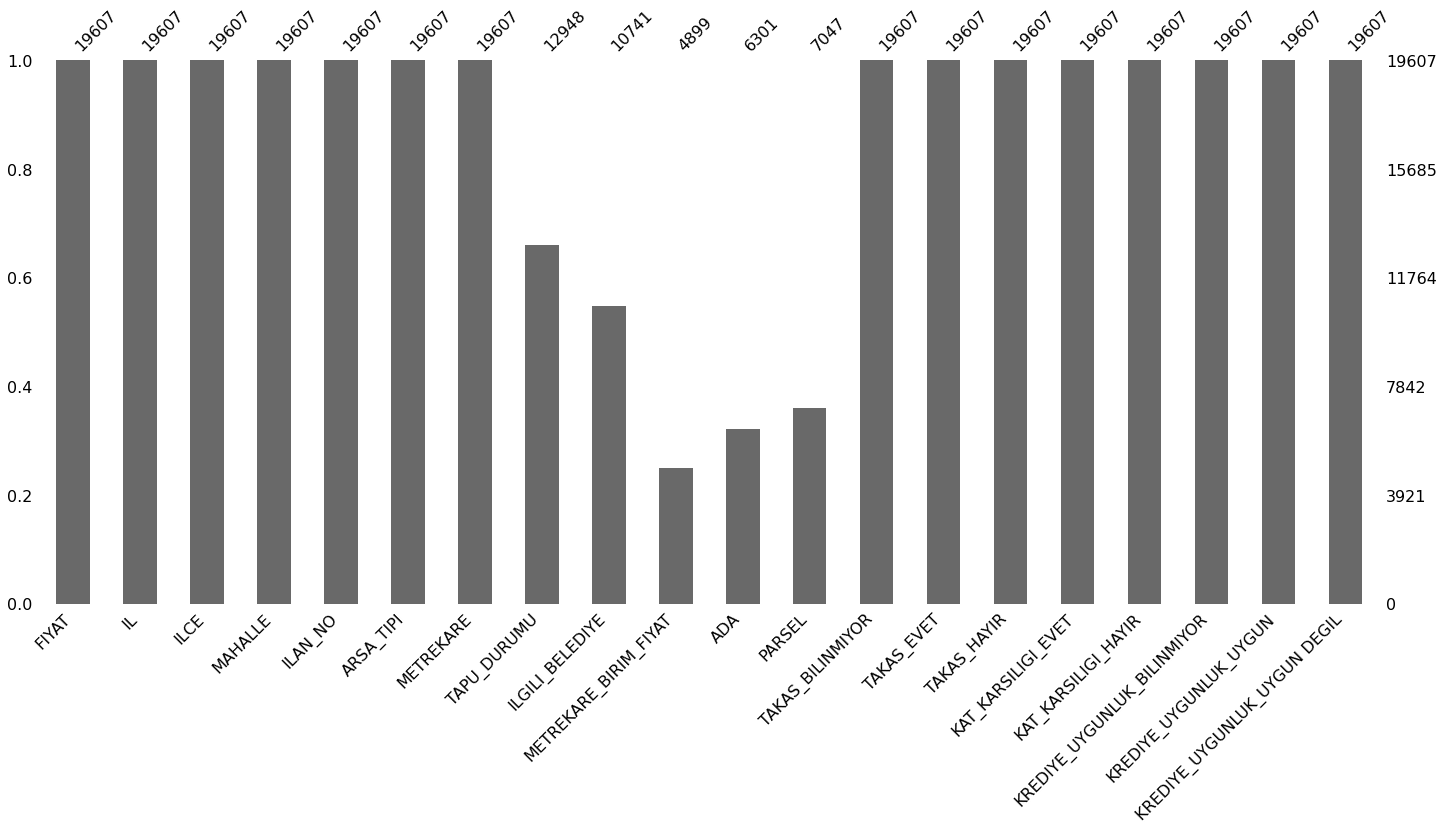

In [9]:
#Eksik veriler gözlemlenir
msno.bar(df_train)

<AxesSubplot:>

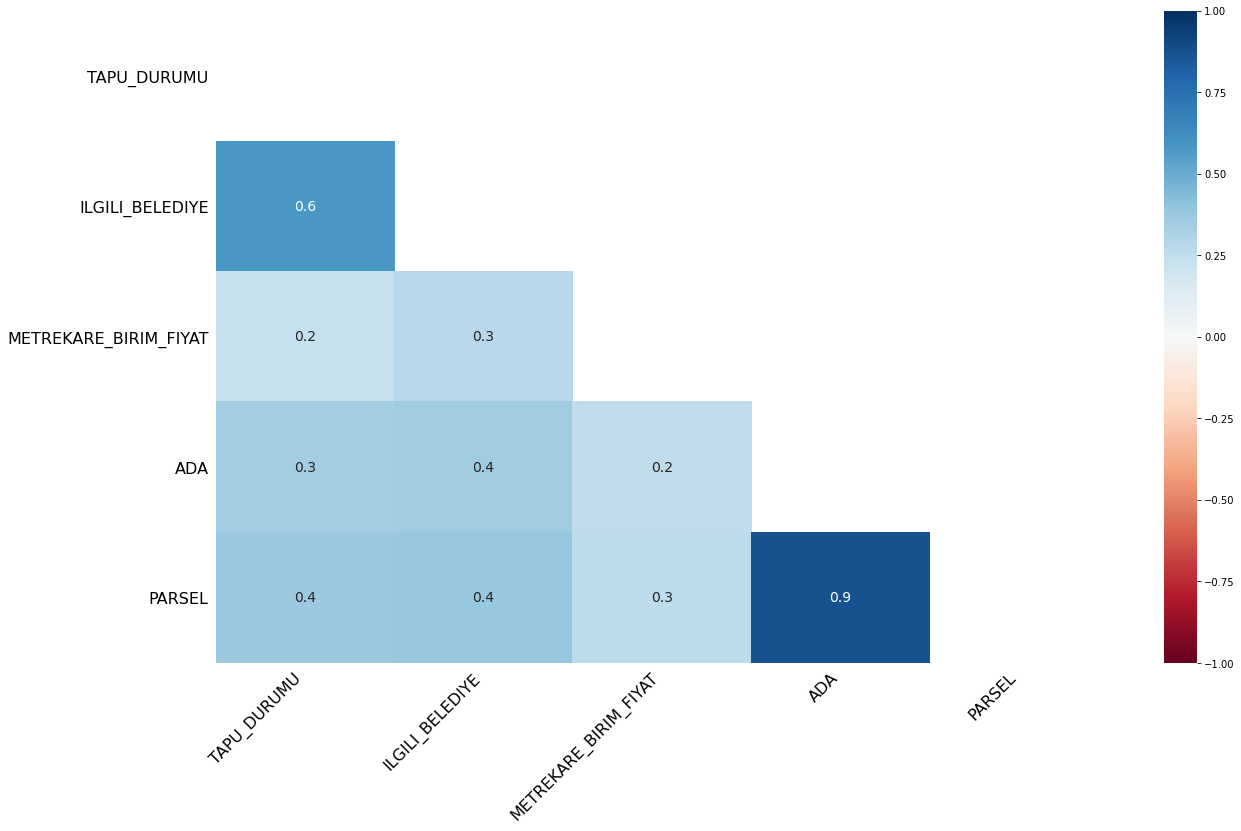

In [10]:
#ısı haritası ile eksiklik korelasyonu : görüldüğü üzere veriler arasında yüksek korelasyn değerleri var. 
#Yani yapısal bir bozukluk var. Rasgele bir şekilde veri silinemez ya da doldurulamaz.
#Özellekile ada izle parsel arasında korelasyon 0.9 aralarında yüksek korelasyon var.
msno.heatmap(df_train)

In [11]:
#Not ada içerisinde parsel barındırır. Bu sebeple aralarında ilişki olduğundan birlikte korelasyona sokulmamalıdır. Sonuç yanlış verir
#Ben direk ada kolonunu kaldırdım
df_train = df_train.drop(["ADA"], axis = 1)


In [12]:
#Kategorik değişkenlerde eksik değer olduğunda önce ilgili algoritmalar ile eksik değerler doldurulur. Sonra one hot dönüşümü yapılır.
df_train["TAPU_DURUMU"].fillna(df_train["TAPU_DURUMU"].mode()[0],inplace=True)
df_train["TAPU_DURUMU"]

0        MUSTAKIL PARSEL
1        MUSTAKIL PARSEL
2        MUSTAKIL PARSEL
3        MUSTAKIL PARSEL
4        MUSTAKIL PARSEL
              ...       
19602    MUSTAKIL PARSEL
19603    MUSTAKIL PARSEL
19604    MUSTAKIL PARSEL
19605    MUSTAKIL PARSEL
19606    MUSTAKIL PARSEL
Name: TAPU_DURUMU, Length: 19607, dtype: object

In [13]:
#Ilce kolonuna göre Ilgili belediye deki boş alanları dolduralım. Kategorik oldukları için direk moda göre atama işlemi yapacağız
#NOT : inplace=true diyerek işlemin verisetinde kalıcı olmasını sağladık
df_train["ILGILI_BELEDIYE"].fillna(df_train["ILGILI_BELEDIYE"].mode()[0],inplace=True)
df_train["ILGILI_BELEDIYE"]


0           AYVALIK
1         YENISEHIR
2           GOLBASI
3           GOLBASI
4           GOLBASI
            ...    
19602       GOLBASI
19603    SEHITKAMIL
19604       GOLBASI
19605        HENDEK
19606       DALAMAN
Name: ILGILI_BELEDIYE, Length: 19607, dtype: object

In [14]:
#metrekare' ye göre metrekare birim fiyatı eksik veri doldurma işlemi
df_train.groupby("METREKARE")["METREKARE_BIRIM_FIYAT"].mean()

METREKARE
1           200.8
2             NaN
4            28.0
10            NaN
11            NaN
            ...  
20210000      NaN
21312312      NaN
25000000      NaN
30000000      NaN
40670103      NaN
Name: METREKARE_BIRIM_FIYAT, Length: 5457, dtype: float64

In [15]:
df_train["METREKARE_BIRIM_FIYAT"].fillna(df_train.groupby("METREKARE")["METREKARE_BIRIM_FIYAT"].transform("mean"),inplace=True
)
df_train["METREKARE_BIRIM_FIYAT"]

0          805.800000
1           35.000000
2        96153.000000
3                 NaN
4          454.600000
             ...     
19602      704.000000
19603       47.000000
19604     7416.586782
19605             NaN
19606      234.000000
Name: METREKARE_BIRIM_FIYAT, Length: 19607, dtype: float64

In [16]:
df_train["METREKARE_BIRIM_FIYAT"].count()

14508

In [17]:
#Eksik kalan yerleri ortalama ile doldurduk
df_train["METREKARE_BIRIM_FIYAT"].fillna(df_train["METREKARE_BIRIM_FIYAT"].median(),inplace=True)
df_train["METREKARE_BIRIM_FIYAT"]

0          805.800000
1           35.000000
2        96153.000000
3          516.950000
4          454.600000
             ...     
19602      704.000000
19603       47.000000
19604     7416.586782
19605      516.950000
19606      234.000000
Name: METREKARE_BIRIM_FIYAT, Length: 19607, dtype: float64

In [18]:
#Metrekareye göre Parsel deki eksik verileri dolduralım
df_train.groupby("METREKARE")["PARSEL"].mean()

METREKARE
1             85.00
2               NaN
4               NaN
10            11.00
11          4034.75
             ...   
20210000       2.00
21312312        NaN
25000000        NaN
30000000        NaN
40670103        NaN
Name: PARSEL, Length: 5457, dtype: float64

In [19]:
df_train["PARSEL"].fillna(df_train.groupby("METREKARE")["PARSEL"].transform("mean"),inplace=True
)
df_train["PARSEL"]

0        1534.333333
1          53.000000
2                NaN
3         659.000000
4         124.125000
            ...     
19602       4.000000
19603     137.000000
19604     584.000000
19605    1622.000000
19606      15.500000
Name: PARSEL, Length: 19607, dtype: float64

In [20]:
df_train["PARSEL"].count()

15893

In [21]:
#Kalan eksik verileri ortalama ile dolduralım
df_train["PARSEL"].fillna(df_train["PARSEL"].median(),inplace=True)
df_train["PARSEL"]

0        1534.333333
1          53.000000
2          89.666667
3         659.000000
4         124.125000
            ...     
19602       4.000000
19603     137.000000
19604     584.000000
19605    1622.000000
19606      15.500000
Name: PARSEL, Length: 19607, dtype: float64

# Artık verileri temizleme aşaması: 

Text(0.5, 1.0, 'FIYAT')

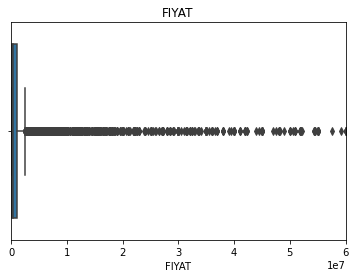

In [23]:
#Fiyat artık tespiti
#plt.figure(figsize=[25,8])
ax = sns.boxplot(x=df_train["FIYAT"])
plt.xlim([-100000,60000000])
plt.title("FIYAT")

In [24]:
#Fiyat Artıkları sildik
df_train = df_train.loc[(df_train["FIYAT"] < 4300000) & (df_train["FIYAT"] > 2000)] #satilik arsa fiyatları var
df_train.reset_index()

,index,FIYAT,IL,ILCE,MAHALLE,ILAN_NO,ARSA_TIPI,METREKARE,TAPU_DURUMU,ILGILI_BELEDIYE,METREKARE_BIRIM_FIYAT,PARSEL,TAKAS_BILINMIYOR,TAKAS_EVET,TAKAS_HAYIR,KAT_KARSILIGI_EVET,KAT_KARSILIGI_HAYIR,KREDIYE_UYGUNLUK_BILINMIYOR,KREDIYE_UYGUNLUK_UYGUN,KREDIYE_UYGUNLUK_UYGUN DEGIL
0,0,165000,BALIKESIR,AYVALIK,ALTINOVA,42916-1540,I_K,255,MUSTAKIL PARSEL,AYVALIK,805.800000,1534.333333,0,1,0,0,1,0,1,0
1,1,240000,BURSA,YENISEHIR,KOZDERE,69245-16,TARLA,7750,MUSTAKIL PARSEL,YENISEHIR,35.000000,53.000000,0,0,1,0,1,0,0,1
2,4,115000,ADIYAMAN,KAHTA,CUMHURIYET,118904-18,M_A,410,MUSTAKIL PARSEL,GOLBASI,454.600000,124.125000,1,0,0,0,1,1,0,0
3,5,77000,ADANA,ALADAG,CERITLER,119467-5,I_K,500,MUSTAKIL PARSEL,GOLBASI,3848.135333,297.949495,1,0,0,0,1,1,0,0
4,6,185000,ANKARA,AKYURT,SAMUT,26985-2054,TARLA,1410,MUSTAKIL PARSEL,AKYURT,180.000000,54.000000,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17911,19602,475000,MALATYA,BATTALGAZI,HIDAYET,110592-126,I_K,458,MUSTAKIL PARSEL,GOLBASI,704.000000,4.000000,0,0,0,0,1,0,0,0
17912,19603,90000,GAZIANTEP,SEHITKAMIL,UCGOZE,7988-58,TARLA,1715,MUSTAKIL PARSEL,SEHITKAMIL,47.000000,137.000000,0,0,1,0,1,0,1,0
17913,19604,315000,ANKARA,GOLBASI,YAYLABAG,1249-1459,TARLA,1000,MUSTAKIL PARSEL,GOLBASI,7416.586782,584.000000,0,0,0,0,1,0,0,0
17914,19605,325000,SAKARYA,HENDEK,SARIDEDE,117558-81,I_K,778,MUSTAKIL PARSEL,HENDEK,516.950000,1622.000000,0,0,0,0,1,0,0,0


Text(0.5, 1.0, 'METREKARE')

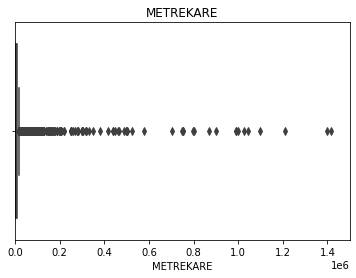

In [25]:
#METREKARE artık tespiti
#plt.figure(figsize=[10,8])
sns.boxplot(x=df_train["METREKARE"])
plt.xlim([-1000,1500000])
plt.title("METREKARE")

In [26]:
Q1=df_train["METREKARE"].quantile(0.25)
Q3=df_train["METREKARE"].quantile(0.75)
IQR=Q3-Q1

In [27]:
Q1

544.0

In [28]:
Q3

7000.0

In [29]:
IQR

6456.0

In [30]:
alt_sinir=Q1-1.5*IQR

In [31]:
ust_sinir=Q3+1.5*IQR

In [32]:
alt_sinir

-9140.0

In [33]:
ust_sinir

16684.0

In [34]:
aykiri=(df_train['METREKARE']>ust_sinir) | (df_train['METREKARE']<alt_sinir)
df_metrekare=df_train['METREKARE']
df_metrekare[aykiri]


32        27000
37       380217
45        25664
59        50000
64        17000
          ...  
19567     22500
19568     30000
19571     99200
19577     33500
19589     17878
Name: METREKARE, Length: 1769, dtype: int64

In [35]:
#aykırı verileri silerek t_metrekare adında kaydettik
#t_metrekare=df_metrekare[~((df_metrekare<(alt_sinir)) | (df_metrekare>(ust_sinir))).any(axis=1)]
df_train = df_train.loc[(df_train["METREKARE"] < ust_sinir) & (df_train["METREKARE"] > alt_sinir)]
df_train.reset_index()

,index,FIYAT,IL,ILCE,MAHALLE,ILAN_NO,ARSA_TIPI,METREKARE,TAPU_DURUMU,ILGILI_BELEDIYE,METREKARE_BIRIM_FIYAT,PARSEL,TAKAS_BILINMIYOR,TAKAS_EVET,TAKAS_HAYIR,KAT_KARSILIGI_EVET,KAT_KARSILIGI_HAYIR,KREDIYE_UYGUNLUK_BILINMIYOR,KREDIYE_UYGUNLUK_UYGUN,KREDIYE_UYGUNLUK_UYGUN DEGIL
0,0,165000,BALIKESIR,AYVALIK,ALTINOVA,42916-1540,I_K,255,MUSTAKIL PARSEL,AYVALIK,805.800000,1534.333333,0,1,0,0,1,0,1,0
1,1,240000,BURSA,YENISEHIR,KOZDERE,69245-16,TARLA,7750,MUSTAKIL PARSEL,YENISEHIR,35.000000,53.000000,0,0,1,0,1,0,0,1
2,4,115000,ADIYAMAN,KAHTA,CUMHURIYET,118904-18,M_A,410,MUSTAKIL PARSEL,GOLBASI,454.600000,124.125000,1,0,0,0,1,1,0,0
3,5,77000,ADANA,ALADAG,CERITLER,119467-5,I_K,500,MUSTAKIL PARSEL,GOLBASI,3848.135333,297.949495,1,0,0,0,1,1,0,0
4,6,185000,ANKARA,AKYURT,SAMUT,26985-2054,TARLA,1410,MUSTAKIL PARSEL,AKYURT,180.000000,54.000000,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16142,19602,475000,MALATYA,BATTALGAZI,HIDAYET,110592-126,I_K,458,MUSTAKIL PARSEL,GOLBASI,704.000000,4.000000,0,0,0,0,1,0,0,0
16143,19603,90000,GAZIANTEP,SEHITKAMIL,UCGOZE,7988-58,TARLA,1715,MUSTAKIL PARSEL,SEHITKAMIL,47.000000,137.000000,0,0,1,0,1,0,1,0
16144,19604,315000,ANKARA,GOLBASI,YAYLABAG,1249-1459,TARLA,1000,MUSTAKIL PARSEL,GOLBASI,7416.586782,584.000000,0,0,0,0,1,0,0,0
16145,19605,325000,SAKARYA,HENDEK,SARIDEDE,117558-81,I_K,778,MUSTAKIL PARSEL,HENDEK,516.950000,1622.000000,0,0,0,0,1,0,0,0


In [36]:
b=df_train["METREKARE_BIRIM_FIYAT"]<345
b

0        False
1         True
4        False
5        False
6         True
         ...  
19602    False
19603     True
19604    False
19605    False
19606     True
Name: METREKARE_BIRIM_FIYAT, Length: 16147, dtype: bool

In [37]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16147 entries, 0 to 19606
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   FIYAT                         16147 non-null  int64  
 1   IL                            16147 non-null  object 
 2   ILCE                          16147 non-null  object 
 3   MAHALLE                       16147 non-null  object 
 4   ILAN_NO                       16147 non-null  object 
 5   ARSA_TIPI                     16147 non-null  object 
 6   METREKARE                     16147 non-null  int64  
 7   TAPU_DURUMU                   16147 non-null  object 
 8   ILGILI_BELEDIYE               16147 non-null  object 
 9   METREKARE_BIRIM_FIYAT         16147 non-null  float64
 10  PARSEL                        16147 non-null  float64
 11  TAKAS_BILINMIYOR              16147 non-null  int64  
 12  TAKAS_EVET                    16147 non-null  int64  
 13  T

In [38]:
df_train.drop(columns=["ILAN_NO","ILGILI_BELEDIYE"], inplace=True)


Text(0.5, 1.0, 'PARSEL')

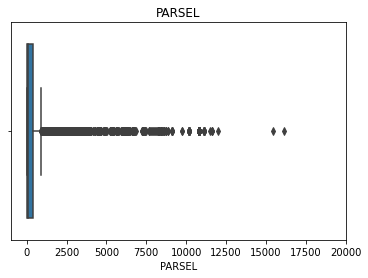

In [39]:
#PARSEL artık tespiti
#plt.figure(figsize=[10,8])
sns.boxplot(x=df_train["PARSEL"])
plt.xlim([-1000,20000])
plt.title("PARSEL")

In [40]:
Q1=df_train["PARSEL"].quantile(0.25)
Q3=df_train["PARSEL"].quantile(0.75)
IQR=Q3-Q1

In [41]:
Q1

10.0

In [42]:
Q3

374.3

In [43]:
IQR

364.3

In [44]:
alt_sinir=Q1-1.5*IQR

In [45]:
ust_sinir=Q3+1.5*IQR

In [46]:
alt_sinir

-536.45

In [47]:
ust_sinir

920.75

In [48]:
aykiri=(df_train['PARSEL']>ust_sinir) | (df_train['PARSEL']<alt_sinir)
df_PARSEL=df_train['PARSEL']
df_PARSEL[aykiri]

0         1534.333333
7        99999.000000
16        1534.333333
23       99999.000000
40        1324.000000
             ...     
19575     1630.333333
19593     1287.222222
19594     3448.000000
19598     1024.982759
19605     1622.000000
Name: PARSEL, Length: 2053, dtype: float64

In [49]:
#df_train = df_train.loc[(df_train["PARSEL"] < 9500) & (df_train["PARSEL"] > 0)]
df_train = df_train.loc[(df_train["PARSEL"] < ust_sinir) & (df_train['PARSEL']>alt_sinir)]

df_train.reset_index()


,index,FIYAT,IL,ILCE,MAHALLE,ARSA_TIPI,METREKARE,TAPU_DURUMU,METREKARE_BIRIM_FIYAT,PARSEL,TAKAS_BILINMIYOR,TAKAS_EVET,TAKAS_HAYIR,KAT_KARSILIGI_EVET,KAT_KARSILIGI_HAYIR,KREDIYE_UYGUNLUK_BILINMIYOR,KREDIYE_UYGUNLUK_UYGUN,KREDIYE_UYGUNLUK_UYGUN DEGIL
0,1,240000,BURSA,YENISEHIR,KOZDERE,TARLA,7750,MUSTAKIL PARSEL,35.000000,53.000000,0,0,1,0,1,0,0,1
1,4,115000,ADIYAMAN,KAHTA,CUMHURIYET,M_A,410,MUSTAKIL PARSEL,454.600000,124.125000,1,0,0,0,1,1,0,0
2,5,77000,ADANA,ALADAG,CERITLER,I_K,500,MUSTAKIL PARSEL,3848.135333,297.949495,1,0,0,0,1,1,0,0
3,6,185000,ANKARA,AKYURT,SAMUT,TARLA,1410,MUSTAKIL PARSEL,180.000000,54.000000,0,1,0,0,1,1,0,0
4,8,285000,MUGLA,MILAS,MESELIK,I_K,710,MUSTAKIL PARSEL,247.666667,0.000000,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14089,19601,350000,ANKARA,GOLBASI,TEPEYURT,TARLA,10000,MUSTAKIL PARSEL,4065.548387,287.333333,0,0,1,0,1,1,0,0
14090,19602,475000,MALATYA,BATTALGAZI,HIDAYET,I_K,458,MUSTAKIL PARSEL,704.000000,4.000000,0,0,0,0,1,0,0,0
14091,19603,90000,GAZIANTEP,SEHITKAMIL,UCGOZE,TARLA,1715,MUSTAKIL PARSEL,47.000000,137.000000,0,0,1,0,1,0,1,0
14092,19604,315000,ANKARA,GOLBASI,YAYLABAG,TARLA,1000,MUSTAKIL PARSEL,7416.586782,584.000000,0,0,0,0,1,0,0,0


In [50]:

df_train = df_train.loc[(df_train["PARSEL"] > 0)]
df_train.reset_index()

,index,FIYAT,IL,ILCE,MAHALLE,ARSA_TIPI,METREKARE,TAPU_DURUMU,METREKARE_BIRIM_FIYAT,PARSEL,TAKAS_BILINMIYOR,TAKAS_EVET,TAKAS_HAYIR,KAT_KARSILIGI_EVET,KAT_KARSILIGI_HAYIR,KREDIYE_UYGUNLUK_BILINMIYOR,KREDIYE_UYGUNLUK_UYGUN,KREDIYE_UYGUNLUK_UYGUN DEGIL
0,1,240000,BURSA,YENISEHIR,KOZDERE,TARLA,7750,MUSTAKIL PARSEL,35.000000,53.000000,0,0,1,0,1,0,0,1
1,4,115000,ADIYAMAN,KAHTA,CUMHURIYET,M_A,410,MUSTAKIL PARSEL,454.600000,124.125000,1,0,0,0,1,1,0,0
2,5,77000,ADANA,ALADAG,CERITLER,I_K,500,MUSTAKIL PARSEL,3848.135333,297.949495,1,0,0,0,1,1,0,0
3,6,185000,ANKARA,AKYURT,SAMUT,TARLA,1410,MUSTAKIL PARSEL,180.000000,54.000000,0,1,0,0,1,1,0,0
4,10,215000,CANAKKALE,AYVACIK,BAHARLAR,I_K,1623,MUSTAKIL PARSEL,516.950000,11.000000,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13345,19601,350000,ANKARA,GOLBASI,TEPEYURT,TARLA,10000,MUSTAKIL PARSEL,4065.548387,287.333333,0,0,1,0,1,1,0,0
13346,19602,475000,MALATYA,BATTALGAZI,HIDAYET,I_K,458,MUSTAKIL PARSEL,704.000000,4.000000,0,0,0,0,1,0,0,0
13347,19603,90000,GAZIANTEP,SEHITKAMIL,UCGOZE,TARLA,1715,MUSTAKIL PARSEL,47.000000,137.000000,0,0,1,0,1,0,1,0
13348,19604,315000,ANKARA,GOLBASI,YAYLABAG,TARLA,1000,MUSTAKIL PARSEL,7416.586782,584.000000,0,0,0,0,1,0,0,0


In [51]:
df_train["PARSEL"].value_counts()

89.666667     2572
1.000000       892
2.000000       351
3.000000       289
5.000000       251
              ... 
392.000000       1
687.000000       1
436.000000       1
55.500000        1
325.000000       1
Name: PARSEL, Length: 903, dtype: int64

In [52]:
df_y=df_train.copy()
#df_y=df_y.iloc[:,1:len(df_y)]


In [53]:
df_y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13350 entries, 1 to 19606
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   FIYAT                         13350 non-null  int64  
 1   IL                            13350 non-null  object 
 2   ILCE                          13350 non-null  object 
 3   MAHALLE                       13350 non-null  object 
 4   ARSA_TIPI                     13350 non-null  object 
 5   METREKARE                     13350 non-null  int64  
 6   TAPU_DURUMU                   13350 non-null  object 
 7   METREKARE_BIRIM_FIYAT         13350 non-null  float64
 8   PARSEL                        13350 non-null  float64
 9   TAKAS_BILINMIYOR              13350 non-null  int64  
 10  TAKAS_EVET                    13350 non-null  int64  
 11  TAKAS_HAYIR                   13350 non-null  int64  
 12  KAT_KARSILIGI_EVET            13350 non-null  int64  
 13  K

In [173]:
#Bu ekilde incelenerek o dağişken içeriğinden kaç tane olduğu ve verisetini nasıl etkileyeceği gözlemlenir.
df_train_D_A_I = df_y.loc[(df_y["ARSA_TIPI"] == "D_A_I") ] 
df_train_D_A_I.reset_index()


,index,FIYAT,IL,ILCE,MAHALLE,ARSA_TIPI,METREKARE,TAPU_DURUMU,METREKARE_BIRIM_FIYAT,PARSEL,TAKAS_BILINMIYOR,TAKAS_EVET,TAKAS_HAYIR,KAT_KARSILIGI_EVET,KAT_KARSILIGI_HAYIR,KREDIYE_UYGUNLUK_BILINMIYOR,KREDIYE_UYGUNLUK_UYGUN,KREDIYE_UYGUNLUK_UYGUN DEGIL


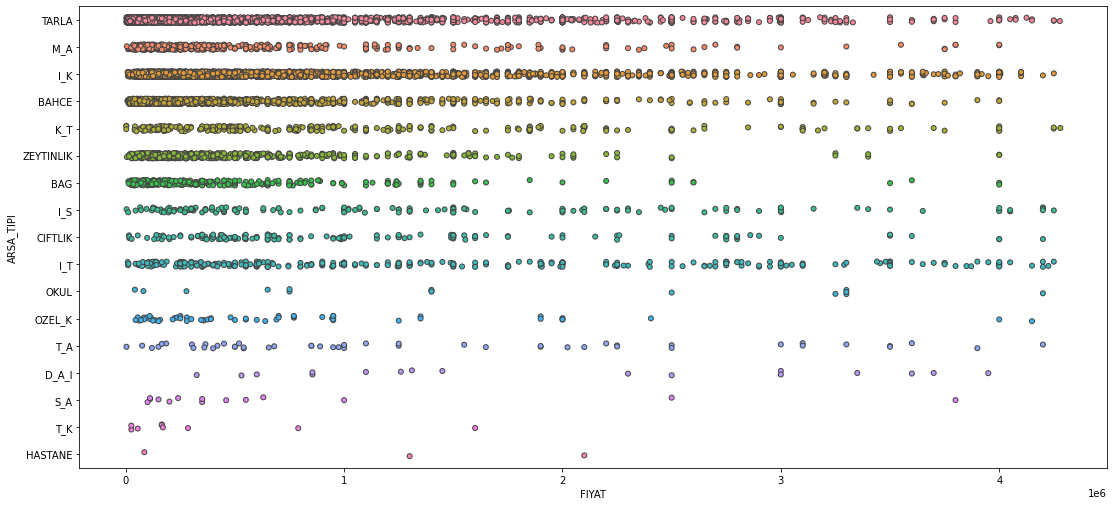

In [54]:
#Arsa tiplerini fiyatlara göre inceleyelim
fig, ax = plt.subplots(figsize=[15,7])
plt.tight_layout() 
a=sns.stripplot(x ="FIYAT", y ="ARSA_TIPI", jitter=True, linewidth=1,data=df_y)

plt.xlabel("FIYAT")
plt.ylabel("ARSA_TIPI")
plt.savefig("Arsa_fiyat.jpeg", bbox_inches = "tight")
plt.show()


In [55]:
df_y.to_csv("guncel_data.csv")

In [56]:
df_y = pd.read_csv('/home/melek/PycharmProjects/webCrawl/guncel_data.csv', encoding = "UTF-8", sep=",")
df=df_y.copy()
df=df.iloc[:,1:len(df)]
df.head()

,FIYAT,IL,ILCE,MAHALLE,ARSA_TIPI,METREKARE,TAPU_DURUMU,METREKARE_BIRIM_FIYAT,PARSEL,TAKAS_BILINMIYOR,TAKAS_EVET,TAKAS_HAYIR,KAT_KARSILIGI_EVET,KAT_KARSILIGI_HAYIR,KREDIYE_UYGUNLUK_BILINMIYOR,KREDIYE_UYGUNLUK_UYGUN,KREDIYE_UYGUNLUK_UYGUN DEGIL
0,240000,BURSA,YENISEHIR,KOZDERE,TARLA,7750,MUSTAKIL PARSEL,35.000000,53.000000,0,0,1,0,1,0,0,1
1,115000,ADIYAMAN,KAHTA,CUMHURIYET,M_A,410,MUSTAKIL PARSEL,454.600000,124.125000,1,0,0,0,1,1,0,0
2,77000,ADANA,ALADAG,CERITLER,I_K,500,MUSTAKIL PARSEL,3848.135333,297.949495,1,0,0,0,1,1,0,0
3,185000,ANKARA,AKYURT,SAMUT,TARLA,1410,MUSTAKIL PARSEL,180.000000,54.000000,0,1,0,0,1,1,0,0
4,215000,CANAKKALE,AYVACIK,BAHARLAR,I_K,1623,MUSTAKIL PARSEL,516.950000,11.000000,0,1,0,0,1,0,1,0


In [57]:
#Arsa tiperi için One Hot dönüşümü yapıldı. 
df=pd.get_dummies(df,columns=["ARSA_TIPI"],prefix=["ARSA_TIPI"])

#df["ARSA_TIPI"] = df["ARSA_TIPI"].factorize()[0]

In [62]:
df["ARSA_TIPI_BAG"] = df["ARSA_TIPI_BAG"].astype(int)
df["ARSA_TIPI_BAHCE"] = df["ARSA_TIPI_BAHCE"].astype(int)
df["ARSA_TIPI_ZEYTINLIK"] = df["ARSA_TIPI_ZEYTINLIK"].astype(int)
df["ARSA_TIPI_T_A"] = df["ARSA_TIPI_T_A"].astype(int)
df["ARSA_TIPI_TARLA"] = df["ARSA_TIPI_TARLA"].astype(int)
df["ARSA_TIPI_OZEL_K"] = df["ARSA_TIPI_OZEL_K"].astype(int)
df["ARSA_TIPI_M_A"] = df["ARSA_TIPI_M_A"].astype(int)
df["ARSA_TIPI_K_T"] = df["ARSA_TIPI_K_T"].astype(int)
df["ARSA_TIPI_I_T"] = df["ARSA_TIPI_I_T"].astype(int)
df["ARSA_TIPI_I_S"] = df["ARSA_TIPI_I_S"].astype(int)
df["ARSA_TIPI_I_K"] = df["ARSA_TIPI_I_K"].astype(int)
df["ARSA_TIPI_D_A_I"] = df["ARSA_TIPI_D_A_I"].astype(int)
df["ARSA_TIPI_OKUL"] = df["ARSA_TIPI_OKUL"].astype(int)
df["ARSA_TIPI_S_A"] = df["ARSA_TIPI_S_A"].astype(int)
df["ARSA_TIPI_CIFTLIK"] = df["ARSA_TIPI_CIFTLIK"].astype(int)
df["ARSA_TIPI_HASTANE"] = df["ARSA_TIPI_HASTANE"].astype(int)


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13350 entries, 0 to 13349
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   FIYAT                         13350 non-null  int64  
 1   IL                            13350 non-null  object 
 2   ILCE                          13350 non-null  object 
 3   MAHALLE                       13350 non-null  object 
 4   METREKARE                     13350 non-null  int64  
 5   TAPU_DURUMU                   13350 non-null  object 
 6   METREKARE_BIRIM_FIYAT         13350 non-null  float64
 7   PARSEL                        13350 non-null  float64
 8   TAKAS_BILINMIYOR              13350 non-null  int64  
 9   TAKAS_EVET                    13350 non-null  int64  
 10  TAKAS_HAYIR                   13350 non-null  int64  
 11  KAT_KARSILIGI_EVET            13350 non-null  int64  
 12  KAT_KARSILIGI_HAYIR           13350 non-null  int64  
 13  K

In [64]:
df.drop(columns=["IL","ILCE","MAHALLE","TAPU_DURUMU"], inplace=True)


In [1]:

#FIYAT = df.FIYAT

# Hedef değerleri 0 ile 1 değerlerine ölçekleyelim
#FIYAT = minmax_scaling(FIYAT, columns = [0])

#Şimdi Orjinal veri ile Ölçeklendirilmiş veriyi çizdirelim
#fig, ax = plt.subplots(1,2)
#sns.distplot(df.FIYAT, ax=ax[0])
#ax[0].set_title("Orjinal Veri")
#sns.distplot(FIYAT, ax=ax[1])
#ax[1].set_title("Ölçeklendirilmiş Veri")

# Değişken çarpıklık durumu gözlemleme ve düzeltme aşaması :

In [65]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
FIYAT,13350.0,612702.582622,755555.923564,2023.000000,150000.0,325000.000000,750000.000000,4.280000e+06
METREKARE,13350.0,3352.137004,3857.421966,1.000000,520.0,1577.500000,5000.000000,1.665700e+04
METREKARE_BIRIM_FIYAT,13350.0,5407.465399,79944.422884,1.000000,292.5,516.950000,853.333333,5.555866e+06
PARSEL,13350.0,160.518359,203.690251,0.333333,10.0,89.666667,263.277778,9.198333e+02
TAKAS_BILINMIYOR,13350.0,0.172584,0.377902,0.000000,0.0,0.000000,0.000000,1.000000e+00
TAKAS_EVET,13350.0,0.175506,0.380413,0.000000,0.0,0.000000,0.000000,1.000000e+00
TAKAS_HAYIR,13350.0,0.450787,0.497591,0.000000,0.0,0.000000,1.000000,1.000000e+00
KAT_KARSILIGI_EVET,13350.0,0.090187,0.286461,0.000000,0.0,0.000000,0.000000,1.000000e+00
KAT_KARSILIGI_HAYIR,13350.0,0.909663,0.286675,0.000000,1.0,1.000000,1.000000,1.000000e+00
KREDIYE_UYGUNLUK_BILINMIYOR,13350.0,0.264494,0.441080,0.000000,0.0,0.000000,1.000000,1.000000e+00


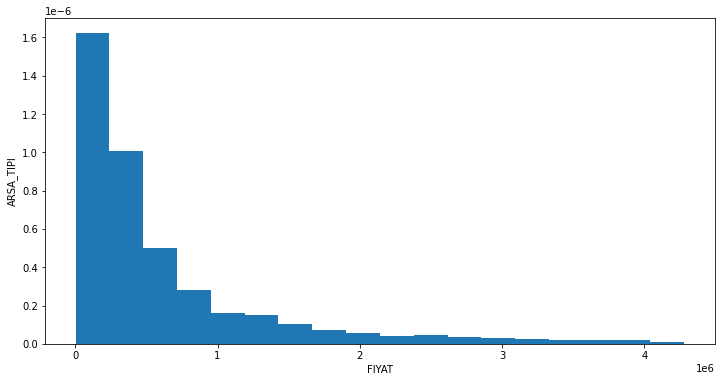

In [66]:
#Sağa çarpık (pozitif kayışlı) dağılımlar, mod'un medyandan, medyanın da aritmetik ortalamadan küçük olduğu dağılımlardır
#Öğrenme düzeyi düşüktür. Test başarısızdır
# fiyat dağılımı
plt.figure(figsize=[12,6])
df["FIYAT"].plot.hist(density=True, bins = 18)
plt.xlabel("FIYAT")
plt.ylabel("ARSA_TIPI")

plt.show()

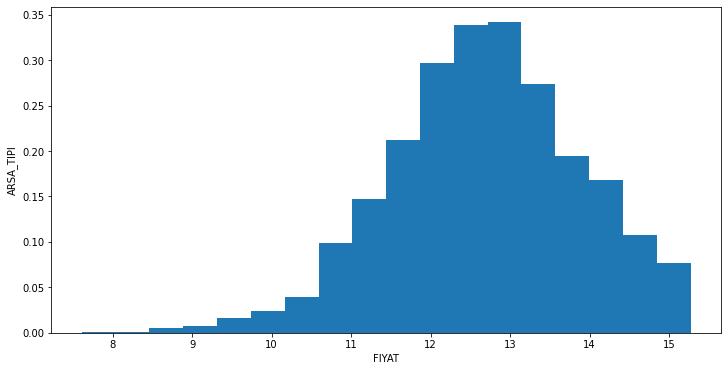

In [67]:
#Fiyat dağılımı
#Hedef değişkenine Logaritmik dönüşüm uygulanarak düzeltildi
plt.figure(figsize=[12,6])
np.log(df["FIYAT"]).plot.hist(density=True, bins = 18)
plt.xlabel("FIYAT")
plt.ylabel("ARSA_TIPI")

plt.show()

In [68]:

df["FIYAT"] = np.log(df["FIYAT"])

In [69]:
df["PARSEL"] = np.log(df["PARSEL"])

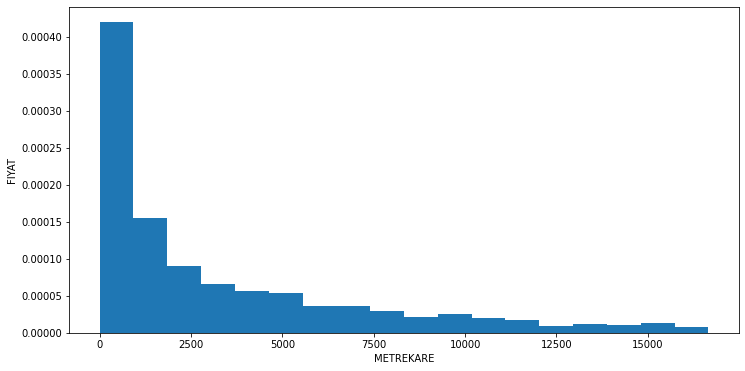

In [70]:
plt.figure(figsize=[12,6])
df["METREKARE"].plot.hist(density=True, bins = 18)
plt.xlabel("METREKARE")
plt.ylabel("FIYAT")
#plt.savefig("aracyasdagılımı.jpeg", dpi = 500)
plt.show()

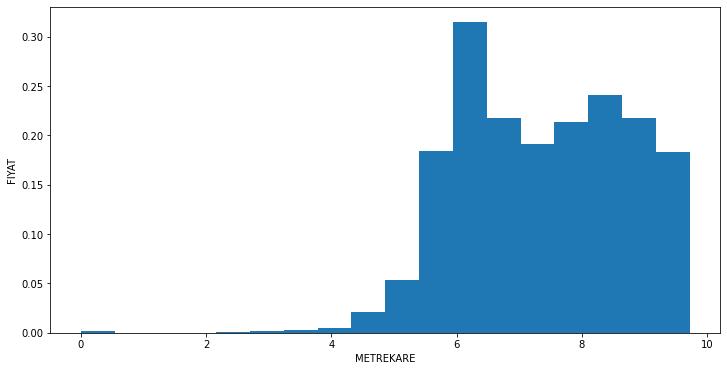

In [71]:
#Hedef değişkenine Logaritmik dönüşüm uygulanarak düzeltildi
plt.figure(figsize=[12,6])
np.log(df["METREKARE"]).plot.hist(density=True, bins = 18)
plt.xlabel("METREKARE")
plt.ylabel("FIYAT")
#plt.savefig("aracyasdagılımı.jpeg", dpi = 500)
plt.show()

In [72]:

df["METREKARE"] = np.log(df["METREKARE"])

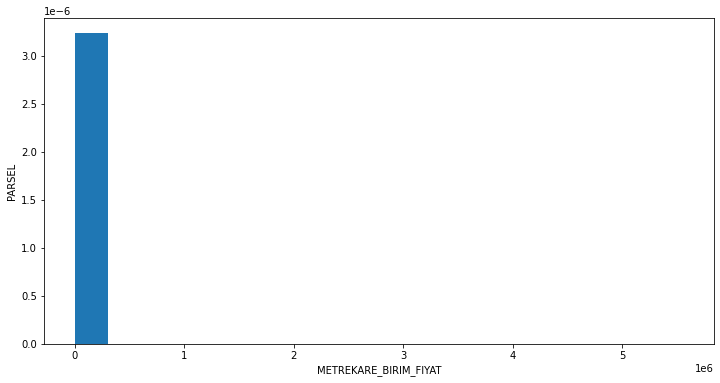

In [73]:
plt.figure(figsize=[12,6])
df["METREKARE_BIRIM_FIYAT"].plot.hist(density=True, bins = 18)
plt.xlabel("METREKARE_BIRIM_FIYAT")
plt.ylabel("PARSEL")

plt.show()

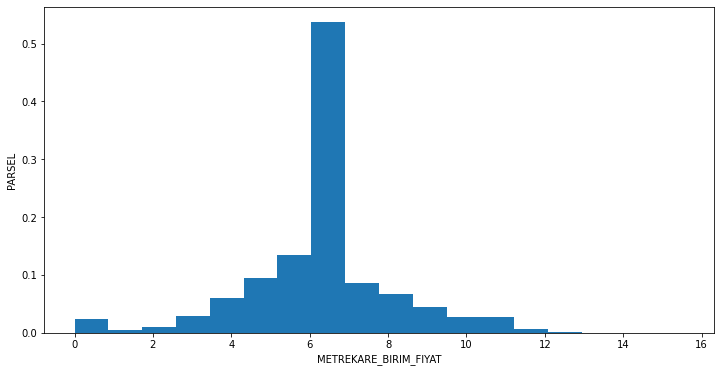

In [74]:
plt.figure(figsize=[12,6])
np.log(df["METREKARE_BIRIM_FIYAT"]).plot.hist(density=True, bins = 18)
plt.xlabel("METREKARE_BIRIM_FIYAT")
plt.ylabel("PARSEL")

plt.show()

In [75]:
df["METREKARE_BIRIM_FIYAT"] = np.log(df["METREKARE_BIRIM_FIYAT"])


In [76]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
FIYAT,13350.0,12.687162,1.193558,7.612337,11.918391,12.691580,13.527828,15.269464
METREKARE,13350.0,7.372009,1.332602,0.000000,6.253829,7.363597,8.517193,9.720586
METREKARE_BIRIM_FIYAT,13350.0,6.247185,1.885890,0.000000,5.678465,6.247946,6.749150,15.530365
PARSEL,13350.0,3.876855,1.935508,-1.098612,2.302585,4.496099,5.573210,6.824192
TAKAS_BILINMIYOR,13350.0,0.172584,0.377902,0.000000,0.000000,0.000000,0.000000,1.000000
TAKAS_EVET,13350.0,0.175506,0.380413,0.000000,0.000000,0.000000,0.000000,1.000000
TAKAS_HAYIR,13350.0,0.450787,0.497591,0.000000,0.000000,0.000000,1.000000,1.000000
KAT_KARSILIGI_EVET,13350.0,0.090187,0.286461,0.000000,0.000000,0.000000,0.000000,1.000000
KAT_KARSILIGI_HAYIR,13350.0,0.909663,0.286675,0.000000,1.000000,1.000000,1.000000,1.000000
KREDIYE_UYGUNLUK_BILINMIYOR,13350.0,0.264494,0.441080,0.000000,0.000000,0.000000,1.000000,1.000000


In [446]:
#Box-Cox Dönüştürme için 
"""from scipy import stats

#min_max ölçeklendirm için
from mlxtend.preprocessing import minmax_scaling

min_max_scaler=preprocessing.MinMaxScaler()
data_scaled=pd.DataFrame(min_max_scaler.fit_transform(df),columns=df.columns)
df=data_scaled"""

In [ ]:
#df_train.corr()

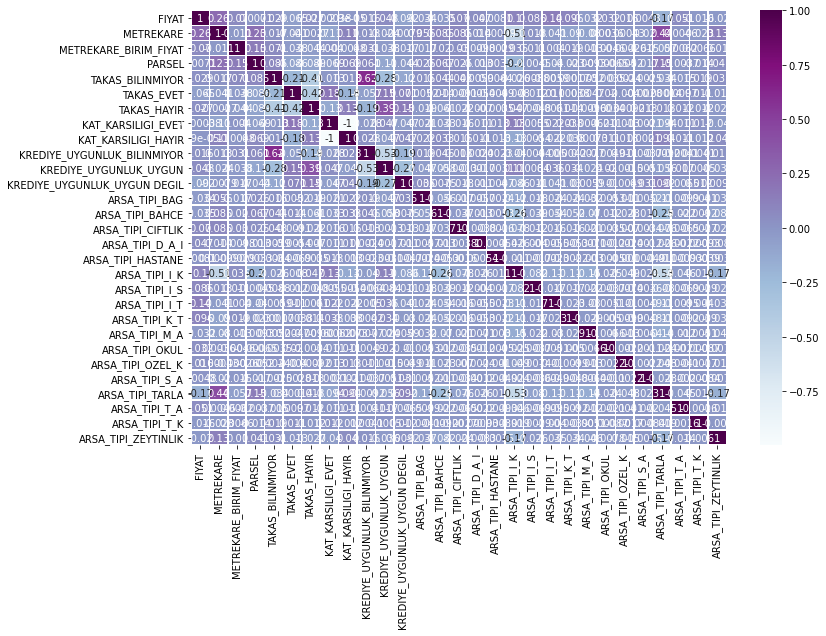

In [78]:

plt.figure(figsize=(12,8))
sns.set_palette("RdBu")
sns.heatmap(df.corr(),linewidths=.5, annot=True, cmap='BuPu');
plt.yticks(rotation=360)
#plt.savefig("heatcorr.jpeg", dpi = 600)
plt.show()

# ExtraTreesRegressor Algoritması ile Select Features :  

önce  feature selection:28 features sayısı.


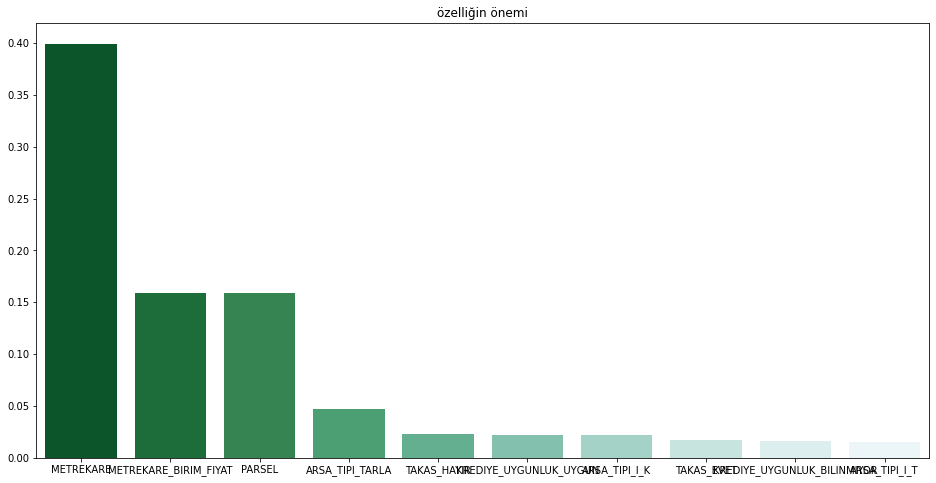

In [79]:

# Özelliği Önem kontrolü
# Özellik seçimi için extra tree classifier'ı kullanıldı.
from sklearn.ensemble import ExtraTreesRegressor
target = df['FIYAT']
features = df.drop(columns = ['FIYAT'])
# sadece sayısal özellikler için mümkün, bu yüzden burada sadece sayısal kullan
non_obj_features = features.describe(exclude = np.object).columns
features = features[non_obj_features]
beforefs = features.columns
print("önce  feature selection:{} features sayısı.".format(len(non_obj_features)))
#classifer for feature selection oluşturulur
forest  = ExtraTreesRegressor(n_estimators = 50)
forest = forest.fit(features, target)
importance_table = pd.Series(forest.feature_importances_, index=features.columns)
importance_table = importance_table.sort_values(ascending = False)
plt.figure(figsize=(16,8))
ax = sns.barplot(x = importance_table.index[:10], y = importance_table.values[:10], palette="BuGn_r")
ax.set_title('özelliğin önemi')
#features: özellik
select_feature = importance_table.index[:10]
#importance_table





In [80]:
select_feature

Index(['METREKARE', 'METREKARE_BIRIM_FIYAT', 'PARSEL', 'ARSA_TIPI_TARLA',
       'TAKAS_HAYIR', 'KREDIYE_UYGUNLUK_UYGUN', 'ARSA_TIPI_I_K', 'TAKAS_EVET',
       'KREDIYE_UYGUNLUK_BILINMIYOR', 'ARSA_TIPI_I_T'],
      dtype='object')

/home/melek/PycharmProjects/webCrawl/venv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/melek/PycharmProjects/webCrawl/venv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/melek/PycharmProjects/webCrawl/venv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displ

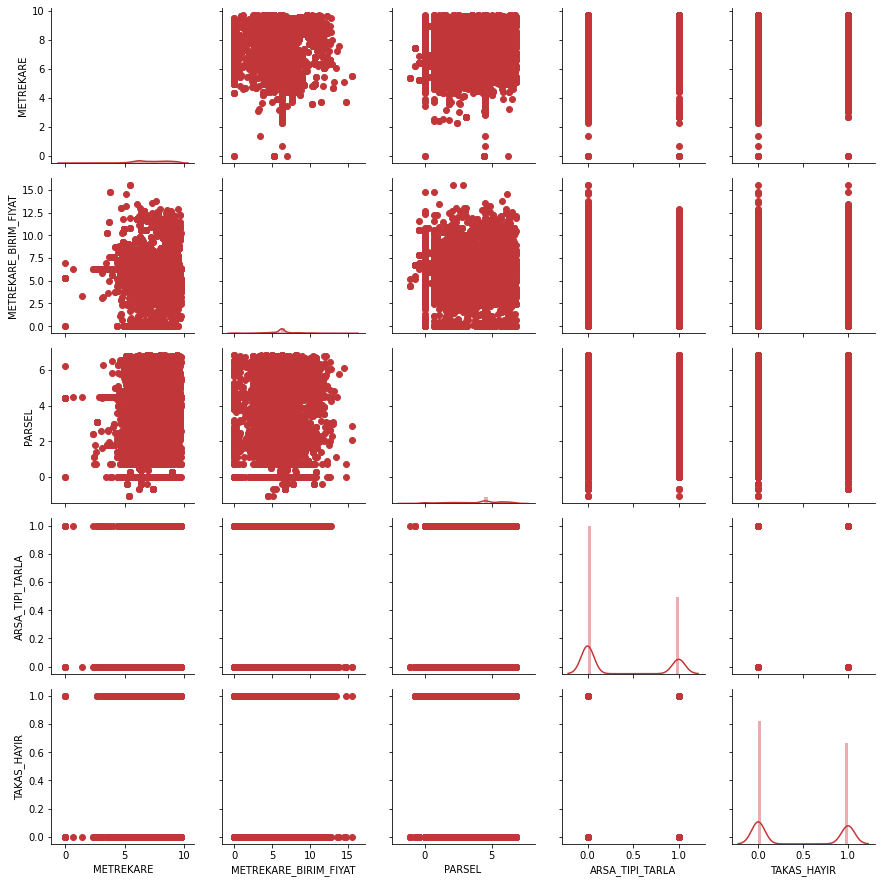

In [81]:
#Regressionda en önemli 10 özelliği seçtik
fig = sns.PairGrid(df[select_feature[0:5]])
fig.map_offdiag(plt.scatter)
fig.map_diag(sns.distplot, bins=30)

/home/melek/PycharmProjects/webCrawl/venv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/melek/PycharmProjects/webCrawl/venv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/melek/PycharmProjects/webCrawl/venv/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displ

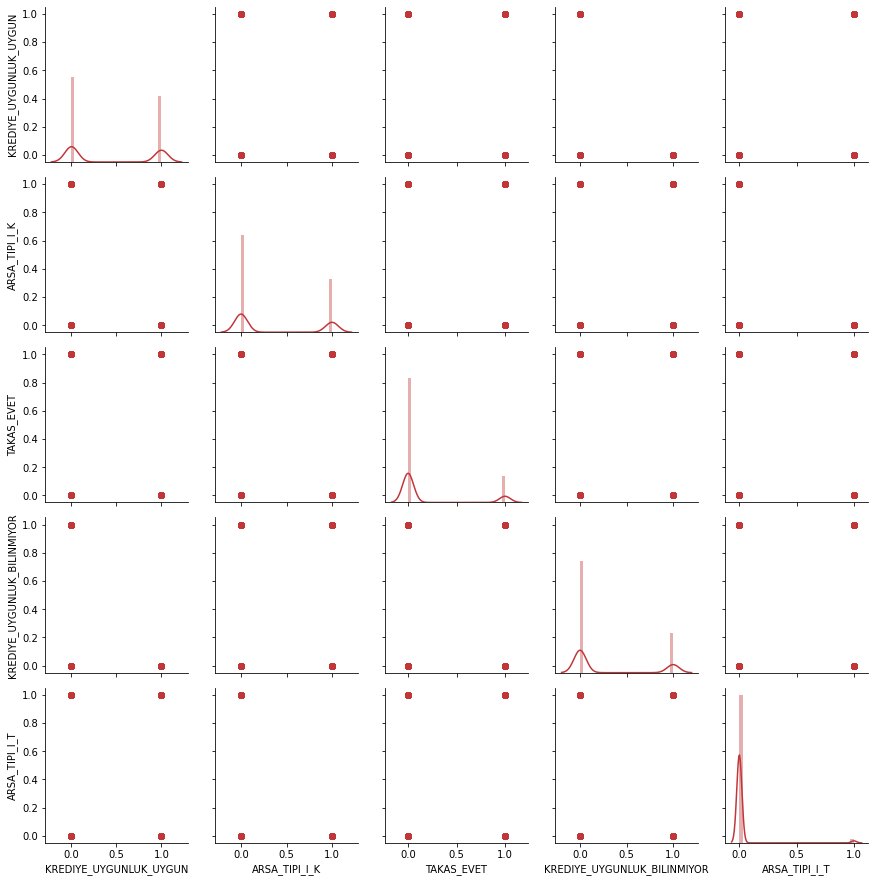

In [82]:
#Başka iki özelliğin seçtiği ikinci beşe geçelim.
fig = sns.PairGrid(df[select_feature[5:]])
fig.map_offdiag(plt.scatter)
fig.map_diag(sns.distplot, bins=30);


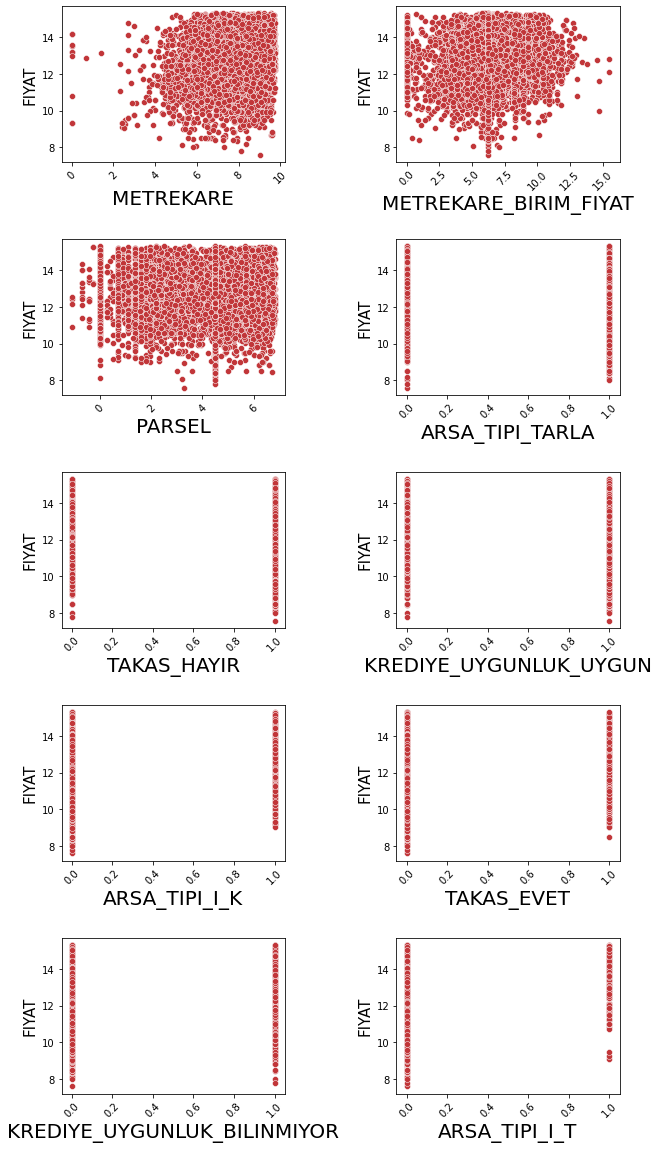

In [83]:
# 1. satış fiyatı ile seçilen 10 özellik arasındaki korelasyon fig = plt.figure(figsize=(10,20))
fig = plt.figure(figsize=(10,20))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(1, 11):
    ax = fig.add_subplot(5, 2, i)
    g = sns.scatterplot(x = df[select_feature[i-1]], y="FIYAT", data=df)
    g.set_xlabel(g.get_xlabel(),fontsize= 20)
    g.set_ylabel(g.get_ylabel(),fontsize= 15)
    plt.xticks(rotation=45)


In [82]:
df["ARSA_TIPI_ZEYTINLIK"].value_counts()



0    12862
1      696
Name: ARSA_TIPI_ZEYTINLIK, dtype: int64

In [ ]:
Index(['METREKARE', 'METREKARE_BIRIM_FIYAT', 'PARSEL', 'ARSA_TIPI_TARLA',
       'TAKAS_HAYIR', 'KREDIYE_UYGUNLUK_UYGUN', 'ARSA_TIPI_I_K', 'TAKAS_EVET',
       'KREDIYE_UYGUNLUK_BILINMIYOR', 'ARSA_TIPI_I_T'],
      dtype='object')

In [95]:
a = sm.add_constant(X)

In [108]:
df["TAKAS_BILINMIYOR"].value_counts()

0    10421
1     2272
Name: TAKAS_EVET, dtype: int64

In [118]:
#model seçimi -Numeric kolonlar ile OLS uyguladık
X = df.drop(columns=["FIYAT","ARSA_TIPI_K_T","ARSA_TIPI_I_K","KREDIYE_UYGUNLUK_BILINMIYOR","TAKAS_EVET","ARSA_TIPI_TARLA","ARSA_TIPI_HASTANE","KAT_KARSILIGI_EVET","KAT_KARSILIGI_HAYIR","ARSA_TIPI_BAHCE","ARSA_TIPI_M_A","ARSA_TIPI_ZEYTINLIK","TAKAS_BILINMIYOR","ARSA_TIPI_T_K","ARSA_TIPI_OKUL","ARSA_TIPI_D_A_I","ARSA_TIPI_S_A","ARSA_TIPI_OZEL_K","ARSA_TIPI_CIFTLIK","ARSA_TIPI_BAG","ARSA_TIPI_S_A","ARSA_TIPI_I_T","ARSA_TIPI_I_S","ARSA_TIPI_T_A","KREDIYE_UYGUNLUK_UYGUN DEGIL"]).astype(float)

#X = df.drop(columns=["FIYAT","TAKAS_BILINMIYOR","KAT_KARSILIGI_HAYIR","KREDIYE_UYGUNLUK_UYGUN DEGIL"]).astype(float)
###X=concat
#X = sm.add_constant(X)
y = df.loc[:,"FIYAT"].astype(float)
###y= np.array(y, dtype=float)
model = sm.OLS(y, X, data=df)
results = model.fit()
results.summary()
#,"ARSA_TIPI_T_A","ARSA_TIPI_M_A","ARSA_TIPI_OZEL_K","ARSA_TIPI_ZEYTINLIK","ARSA_TIPI_BAG","ARSA_TIPI_BAHCE","KREDIYE_UYGUNLUK_UYGUN DEGIL","TAKAS_BILINMIYOR"

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  FIYAT   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.976
Method:                 Least Squares   F-statistic:                          1.104e+05
Date:                Fri, 05 Feb 2021   Prob (F-statistic):                        0.00
Time:                        14:01:28   Log-Likelihood:                         -27913.
No. Observations:               13350   AIC:                                  5.584e+04
Df Residuals:                   13345   BIC:                                  5.587e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
METREKARE                  1.2219      0.008    155.055      0.000       1.206       1.237
METREKARE_BIRIM_FIYAT      0.4777      0.008     60.488      0.000       0.462       0.493
PARSEL                     0.0134      0.009      1.468      0.142      -0.005       0.031
TAKAS_HAYIR                0.3793      0.037     10.300      0.000       0.307       0.451
KREDIYE_UYGUNLUK_UYGUN     0.5408      0.037     14.632      0.000       0.468       0.613
==============================================================================
Omnibus:                      261.589   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              469.066
Skew:                          -0.149   Prob(JB):                    1.39e-102
Kurtosis:                       3.868   Cond. No.                         27.3
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [465]:
#Box-Cox Dönüştürme için 
from scipy import stats

#min_max ölçeklendirm için
from mlxtend.preprocessing import minmax_scaling

min_max_scaler=preprocessing.MinMaxScaler()
data_scaled=pd.DataFrame(min_max_scaler.fit_transform(X),columns=X.columns)
X=data_scaled

In [467]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
METREKARE,13558.0,0.752660,0.137690,0.0,0.636248,0.751955,0.867617,1.0
METREKARE_BIRIM_FIYAT,13558.0,0.401984,0.121146,0.0,0.365636,0.402305,0.434326,1.0
PARSEL,13558.0,0.629229,0.243708,0.0,0.429518,0.706525,0.842548,1.0
TAKAS_EVET,13558.0,0.174436,0.379498,0.0,0.000000,0.000000,0.000000,1.0
TAKAS_HAYIR,13558.0,0.450804,0.497592,0.0,0.000000,0.000000,1.000000,1.0
ARSA_TIPI_BAHCE,13558.0,0.110488,0.313509,0.0,0.000000,0.000000,0.000000,1.0
ARSA_TIPI_I_K,13558.0,0.349093,0.476701,0.0,0.000000,0.000000,1.000000,1.0
ARSA_TIPI_M_A,13558.0,0.037174,0.189194,0.0,0.000000,0.000000,0.000000,1.0
ARSA_TIPI_TARLA,13558.0,0.347028,0.476042,0.0,0.000000,0.000000,1.000000,1.0
ARSA_TIPI_ZEYTINLIK,13558.0,0.051335,0.220688,0.0,0.000000,0.000000,0.000000,1.0


In [98]:
df.to_csv("son_data.csv")

In [136]:
def get_model(X,y):

#    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df_train.index, test_size=0.33, random_state=0)

    #test setini ayırdık
    X, X_test, y, y_test = train_test_split(X, y, test_size = .40, random_state = 42)

    #train val ayırdık
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .40, random_state = 42)

    #LinearReg
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    print(f'Linear Regression train R^2: {lm.score(X_train, y_train):.3f}')
    print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')
    print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

    #Poly
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train.values)
    X_val_poly = poly.transform(X_val.values)
    X_test_poly = poly.transform(X_test.values)
    lm_poly = LinearRegression()

    lm_poly.fit(X_train_poly, y_train)
    print(f'Degree 2 polynomial regression train R^2: {lm_poly.score(X_train_poly, y_train):.3f}')
    print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')
    print(f'Degree 2 polynomial regression test R^2: {lm_poly.score(X_test_poly, y_test):.3f}')

    #PolyRidge
    lm_poly_ri = Ridge(alpha=0.5)
    lm_poly_ri.fit(X_train_poly, y_train)
    print(f'Ridge polynomial regression train R^2: {lm_poly_ri.score(X_train_poly, y_train):.3f}')
    print(f'Ridge polynomial regression val R^2: {lm_poly_ri.score(X_val_poly, y_val):.3f}')
    print(f'Ridge polynomial regression test R^2: {lm_poly_ri.score(X_test_poly, y_test):.3f}')

    #Ridge
    lm_reg = Ridge(alpha=0.5)
    lm_reg.fit(X_train, y_train)
    print(f'Ridge Regression train R^2: {lm_reg.score(X_train, y_train):.3f}')
    print(f'Ridge Regression val R^2: {lm_reg.score(X_val, y_val):.3f}')
    print(f'Ridge Regression test R^2: {lm_reg.score(X_test, y_test):.3f}')

    #Lasso
    lm_las = Lasso(alpha=0.5)
    lm_las.fit(X_train, y_train)
    print(f'Lasso Regression train R^2: {lm_las.score(X_train, y_train):.3f}')
    print(f'Lasso Regression val R^2: {lm_las.score(X_val, y_val):.3f}')
    print(f'Lasso Regression test R^2: {lm_las.score(X_test, y_test):.3f}')


In [137]:
def cross_vals(X,y):

    #test setini ayırdık
    X, X_test, y, y_test = train_test_split(X, y, test_size = .40, random_state = 42)

    #train val ayırdık
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .40, random_state = 42)

    #LinearCV
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    print(f'Linear Regression CV train : {cross_val_score(lm, X_train, y_train, cv=8).mean()}')

    #PolyCV
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train.values)
    X_val_poly = poly.transform(X_val.values)
    X_test_poly = poly.transform(X_test.values)
    lm_poly = LinearRegression()
    lm_poly.fit(X_train_poly, y_train)
    print(f'Polynomial CV train : {cross_val_score(lm_poly, X_train_poly, y_train, cv=8).mean()}')

    #PolyRidge
    lm_poly_ri = Ridge(alpha=0.5)
    lm_poly_ri.fit(X_train_poly, y_train)
    print(f'Polynomial Ridge CV train : {cross_val_score(lm_poly_ri, X_train_poly, y_train, cv=8).mean()}')

    #Ridge
    lm_reg = Ridge(alpha=0.5)
    lm_reg.fit(X_train, y_train)
    print(f'Ridge CV train : {cross_val_score(lm_reg, X_train, y_train, cv=8).mean()}')

    #Lasso
    lm_las = Lasso(alpha=0.5)
    lm_las.fit(X_train, y_train)
    print(f'Lasso CV train : {cross_val_score(lm_las, X_train, y_train, cv=8).mean()}')

In [138]:
get_model(X,y)

Linear Regression train R^2: 0.220
Linear Regression val R^2: 0.264
Linear Regression test R^2: 0.227
Degree 2 polynomial regression train R^2: 0.262
Degree 2 polynomial regression val R^2: 0.277
Degree 2 polynomial regression test R^2: 0.251
Ridge polynomial regression train R^2: 0.262
Ridge polynomial regression val R^2: 0.278
Ridge polynomial regression test R^2: 0.251
Ridge Regression train R^2: 0.220
Ridge Regression val R^2: 0.264
Ridge Regression test R^2: 0.227
Lasso Regression train R^2: 0.000
Lasso Regression val R^2: -0.001
Lasso Regression test R^2: -0.000


In [139]:

cross_vals(X,y)

Linear Regression CV train : 0.2151503445285473
Polynomial CV train : 0.24085513593235874
Polynomial Ridge CV train : 0.2409727873660646
Ridge CV train : 0.2151562728255374
Lasso CV train : -0.0009629271840573828


In [140]:
#mutlak hatalara bakalım
from sklearn.metrics import mean_absolute_error

def MAE(X,y):

    #test setini ayırdık
    X, X_test, y, y_test = train_test_split(X, y, test_size = .40, random_state = 42)

    #train val ayırdık
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .40, random_state = 42)

    #Linear
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    y_pred_lm = lm.predict(X_test)
    print(f'Linear Regression MAE : {mean_absolute_error(y_test, y_pred_lm)}')

    #Poly
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train.values)
    X_val_poly = poly.transform(X_val.values)
    X_test_poly = poly.transform(X_test.values)
    lm_poly = LinearRegression()
    lm_poly.fit(X_train_poly, y_train)
    y_pred = lm_poly.predict(X_test_poly)
    print(f'Polynomial MAE : {mean_absolute_error(y_test, y_pred)}')

    #PolyRidge
    lm_poly_ri = Ridge(alpha=0.5)
    lm_poly_ri.fit(X_train_poly, y_train)
    y_pred_polyrid = lm_poly_ri.predict(X_test_poly)
    print(f'Poly Ridge MAE : {mean_absolute_error(y_test, y_pred_polyrid)}')

    #Ridge
    lm_reg = Ridge(alpha=0.5)
    lm_reg.fit(X_train, y_train)
    y_pred_ri = lm_reg.predict(X_test)
    print(f'Ridge MAE : {mean_absolute_error(y_test, y_pred_ri)}')

    #Lasso
    lm_las = Lasso(alpha=0.5)
    lm_las.fit(X_train, y_train)
    y_pred_la = lm_las.predict(X_test)
    print(f'Lasso MAE : {mean_absolute_error(y_test, y_pred_la)}')

In [141]:
MAE(X,y)

Linear Regression MAE : 0.8100916443447247
Polynomial MAE : 0.8000574279649516
Poly Ridge MAE : 0.8001617482863649
Ridge MAE : 0.8101244482497842
Lasso MAE : 0.9394162808799015


In [154]:
X = df.drop(columns=["FIYAT","KAT_KARSILIGI_EVET","KREDIYE_UYGUNLUK_BILINMIYOR","ARSA_TIPI_K_T",
                     "KAT_KARSILIGI_HAYIR","ARSA_TIPI_HASTANE","TAKAS_BILINMIYOR","ARSA_TIPI_T_K",
                     "ARSA_TIPI_OKUL","ARSA_TIPI_D_A_I","ARSA_TIPI_S_A","ARSA_TIPI_OZEL_K",
                     "ARSA_TIPI_CIFTLIK","ARSA_TIPI_BAG","ARSA_TIPI_S_A","ARSA_TIPI_I_T","ARSA_TIPI_I_S",
                     "ARSA_TIPI_T_A","KREDIYE_UYGUNLUK_UYGUN DEGIL"]).astype(float)
y = df.loc[:,"FIYAT"].astype(float)
model = sm.OLS(y, X, data=df)
results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  FIYAT   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                          7.819e+04
Date:                Fri, 05 Feb 2021   Prob (F-statistic):                        0.00
Time:                        14:23:10   Log-Likelihood:                         -25006.
No. Observations:               13350   AIC:                                  5.003e+04
Df Residuals:                   13339   BIC:                                  5.012e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
METREKARE                  1.3111      0.008    168.857      0.000       1.296       1.326
METREKARE_BIRIM_FIYAT      0.2795      0.007     41.190      0.000       0.266       0.293
PARSEL                     0.0541      0.007      7.296      0.000       0.040       0.069
TAKAS_EVET                 0.4948      0.042     11.677      0.000       0.412       0.578
TAKAS_HAYIR                0.4643      0.035     13.355      0.000       0.396       0.532
KREDIYE_UYGUNLUK_UYGUN     0.0382      0.033      1.174      0.240      -0.026       0.102
ARSA_TIPI_BAHCE            0.1995      0.058      3.453      0.001       0.086       0.313
ARSA_TIPI_I_K              2.1227      0.043     49.790      0.000       2.039       2.206
ARSA_TIPI_M_A              1.3153      0.079     16.587      0.000       1.160       1.471
ARSA_TIPI_TARLA           -0.5739      0.049    -11.758      0.000      -0.670      -0.478
ARSA_TIPI_ZEYTINLIK       -0.3075      0.074     -4.165      0.000      -0.452      -0.163
==============================================================================
Omnibus:                     1363.501   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5669.348
Skew:                           0.442   Prob(JB):                         0.00
Kurtosis:                       6.068   Cond. No.                         79.6
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [145]:
X = sm.add_constant(X)

In [155]:
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.metrics import accuracy_score

def graphs_PolyRidge(X,y):
    #Test veriler(X= modele dahil edilen tüm sayısal kolonlar, y= FIYAT kolonu)
    X, X_test, y, y_test = train_test_split(X, y, test_size = .20, random_state = 42)
    # Train verler
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .20, random_state = 42)

    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train.values)
    X_val_poly = poly.transform(X_val.values)
    X_test_poly = poly.transform(X_test.values)

    lm_poly_ri = Ridge(alpha=0.5)
    model=lm_poly_ri.fit(X_train_poly, y_train)
    score=model.score(X_train_poly, y_train)
    print("model score:",score)
    print(f'Accuracy: {round(score*100,2)}%')
    y_pred = model.predict(X_test_poly)
    
    """lm_reg = Ridge(alpha=0.5)
    model=lm_reg.fit(X_train, y_train)
    y_pred = model.predict(X_test)"""


    """lm = LinearRegression()
    model=lm.fit(X_train, y_train)
    y_pred = model.predict(X_test)"""

    ols5 = sm.OLS(y_pred, X_test)
    print(ols5.fit().summary())


    """a = np.array([8.44,5.192957,3.988984,1.0,0.0,0.0,0.0,0.0,1.0,0.0])
    a = a.reshape(-1, len(model))
    print("a: ",model.predict(a))"""





    yazdir=pd.DataFrame({"gercek_fiyat":y_test[0:10],
                         "tahmin_fiyat":y_pred[0:10]})
    print(yazdir)
    #print(y_pred[0:10])

    #result = lm_reg.predict(X_test)
    handin = pd.DataFrame({'Gercek_Fiyat':y_test ,'Tahmin_Fiyat': y_pred})
    handin.to_csv('TAHMIN.csv', index=False)

    plt.figure(figsize=[20,10])

    #reg fit plot
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred, alpha=.5, c='brown')
    plt.plot(np.log(np.linspace(-100000,20000000,8)), np.log(np.linspace(-100000,20000000,8)))
    #plt.title('Tahmin Değerleri vs. Gerçek değerler', fontsize=22)
    plt.title("Regression Fit")
    plt.xlabel('Gerçek Değerler')
    plt.ylabel('Tahmin Değerleri')
    plt.plot(y_test,y_test,'r')



    #residual plot
    plt.subplot(1, 3, 2)
    res = y_test - y_pred
    plt.scatter(y_pred, res, alpha=.5)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")

    #Q-Q plot
    plt.subplot(1, 3, 3)
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")





model score: 0.2705339310667523
Accuracy: 27.05%
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                          2.689e+04
Date:                Fri, 05 Feb 2021   Prob (F-statistic):                        0.00
Time:                        15:16:09   Log-Likelihood:                         -4275.5
No. Observations:                2670   AIC:                                      8573.
Df Residuals:                    2659   BIC:                                      8638.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|     

/home/melek/PycharmProjects/webCrawl/venv/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in log


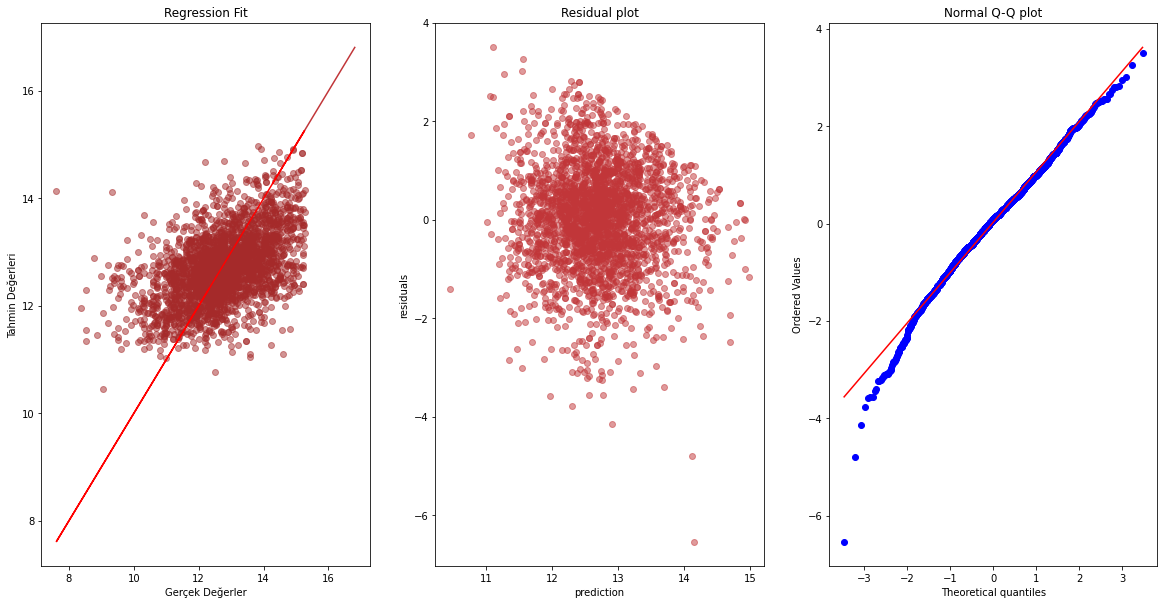

In [180]:
graphs_PolyRidge(X,y)

In [157]:
import scipy.stats as stats
import statsmodels.api as sm

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X.values)


lm_poly_ri = Ridge(alpha=0.5)
model=lm_poly_ri.fit(X_train_poly, y)
score=model.score(X_train_poly, y)
print(score)

0.268034362258894


In [158]:
import pickle
import pickle as p

In [181]:
filename = 'Model.pkl'
pickle.dump(model, open(filename, 'wb'))



In [182]:
model = p.load(open('/home/melek/PycharmProjects/webCrawl/Model.pkl', 'rb'))

In [481]:
Q=df["FIYAT"]>12.000
Q.head()

0     True
1    False
2    False
3     True
4     True
Name: FIYAT, dtype: bool

In [175]:
df.head()

,FIYAT,METREKARE,METREKARE_BIRIM_FIYAT,PARSEL,TAKAS_BILINMIYOR,TAKAS_EVET,TAKAS_HAYIR,KAT_KARSILIGI_EVET,KAT_KARSILIGI_HAYIR,KREDIYE_UYGUNLUK_BILINMIYOR,...,ARSA_TIPI_I_T,ARSA_TIPI_K_T,ARSA_TIPI_M_A,ARSA_TIPI_OKUL,ARSA_TIPI_OZEL_K,ARSA_TIPI_S_A,ARSA_TIPI_TARLA,ARSA_TIPI_T_A,ARSA_TIPI_T_K,ARSA_TIPI_ZEYTINLIK
0,12.388394,8.955448,3.555348,3.970292,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,11.652687,6.016157,6.119418,4.821289,1,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,0
2,11.251561,6.214608,8.255344,5.696924,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,12.128111,7.251345,5.192957,3.988984,0,1,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
4,12.278393,7.392032,6.247946,2.397895,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [183]:
#data = [[8.44],[5.192957],[3.988984],[1.0],[0.0],[1.0],[0.0],[0.0],[0.0],[1.0],[0.0]]

data = [[8.955448],[3.555348],[5.0],[1.0],[0.0],[0.0],[1.0],[0.0],[0.0],[0.0],[0.0]]

data=np.transpose(data)
model.predict(data)

model

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 78 is different from 11)

In [149]:
data = [[8.44],[5.192957],[3.988984],[1.0],[0.0],[0.0],[1.0],[0.0],[1.0],[0.0],[0.0],[0.0],[1.0],[0.0]]
data = data.reshape(-1, 15)
data=pd.DataFrame(data)

AttributeError: 'list' object has no attribute 'reshape'

In [191]:
data = [[844] 
        [52]
        [30]
        [1]
        [0]
        [0]
        [1]
        [0]
        [0]
        [0]
        [0]]

data=pd.DataFrame(data)

IndexError: list index out of range

In [177]:
new_input= [[8.955448],[3.555348],[5.0],[1.0],[0.0],[0.0],[1.0],[0.0],[0.0],[0.0],[0.0]]

In [178]:
new_output = model.predict(new_input)
# summarize input and output
print(new_input, new_output)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 78 is different from 1)

In [185]:
y=model.predict(data)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 78 is different from 11)

In [179]:
a = np.array( [[8.955448],[3.555348],[5.0],[1.0],[0.0],[0.0],[1.0],[0.0],[0.0],[0.0],[0.0]])
#data = a.reshape(14, 1)
print("a: ",model.predict(a))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 78 is different from 1)